# Lorenz63 Performance

In [5]:
import numpy as np
import torch

import sys
sys.path.append("../..")

%matplotlib widget

In [6]:
from src.models.koopman_ae import KoopmanAE

koopman_ae_model = KoopmanAE(input_dim=3, latent_dim=32)

In [8]:
ckpt = torch.load("../../results/checkpoints/koopman_ae_lorenz63.pt")
koopman_ae_model.load_state_dict(ckpt['model_state_dict'])

print(koopman_ae_model)

KoopmanAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=3, bias=True)
    )
  )
  (koopman): KoopmanOperator()
)


In [9]:
init_state = np.array([1.0, 1.0, 1.0], dtype=np.float32)

original_data = np.load("../../data/lorenz63/lorenz63data.npy")

In [11]:
prediction_step = 501

x0 = torch.tensor(original_data, dtype=torch.float32)

pred = torch.ones_like(x0)

temp_t, temp_tp1 = x0[0], x0[1]

for i in range(prediction_step):
    pred_out = koopman_ae_model(temp_t, temp_tp1)
    temp_t, temp_tp1 = temp_tp1, pred_out["x_tp1_pred"]
    pred[i] = pred_out["x_tp1_pred"]

# for i in range(prediction_step):
#     pred_out = koopman_ae_model(x0[i], x0[i+1])
#     pred[i] = pred_out["x_tp1_pred"]

pred = pred[:prediction_step]
print(pred.shape)
print(pred[-10:], pred.shape)

np.save("../../results/predictions/koopman_ae_lorenz63_preds.npy", pred.cpu().detach().numpy())

torch.Size([501, 3])
tensor([[ -8.3688, -13.8225,  16.7915],
        [ -8.3676, -13.8240,  16.7839],
        [ -8.8971, -14.4392,  17.6452],
        [ -8.8963, -14.4413,  17.6377],
        [ -9.4279, -15.0153,  18.5978],
        [ -9.4275, -15.0181,  18.5906],
        [ -9.9551, -15.5424,  19.6436],
        [ -9.9552, -15.5458,  19.6367],
        [-10.4738, -16.0135,  20.7754],
        [-10.4742, -16.0174,  20.7689]], grad_fn=<SliceBackward>) torch.Size([501, 3])


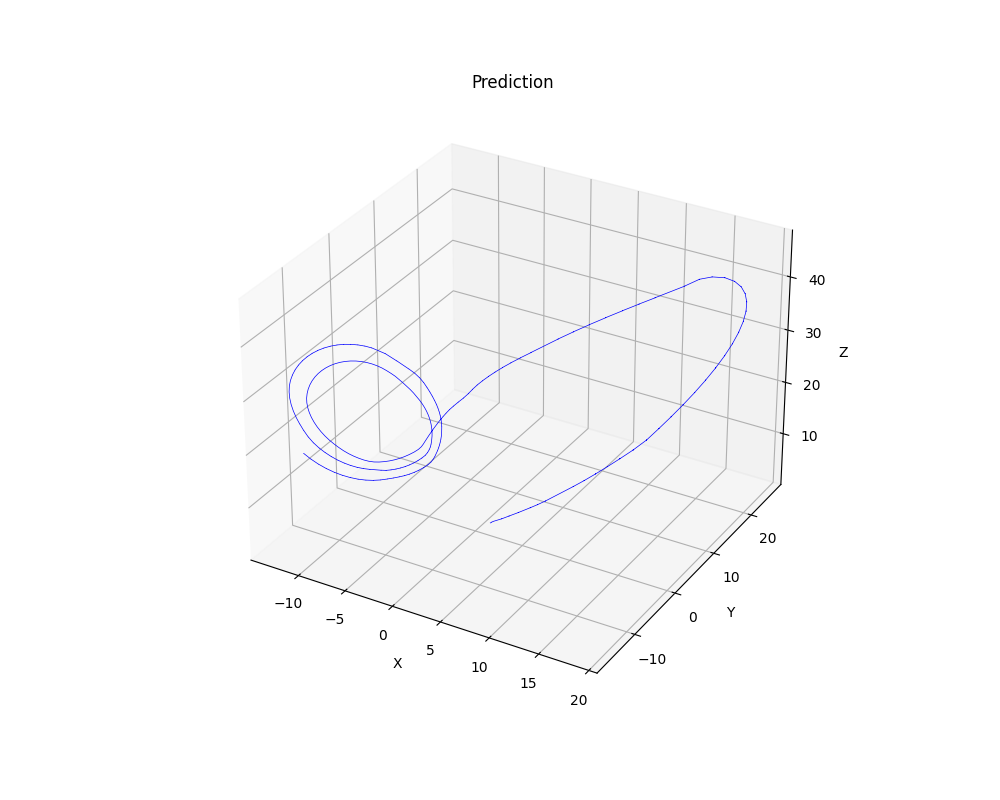

In [12]:
from data.lorenz63.lorenz63static import plot_trajectory_3d

plot_trajectory_3d(pred.cpu().detach().numpy(), title="Prediction", figsize=(10, 8), linewidth=0.5, color='blue', show=True, save_path=None)

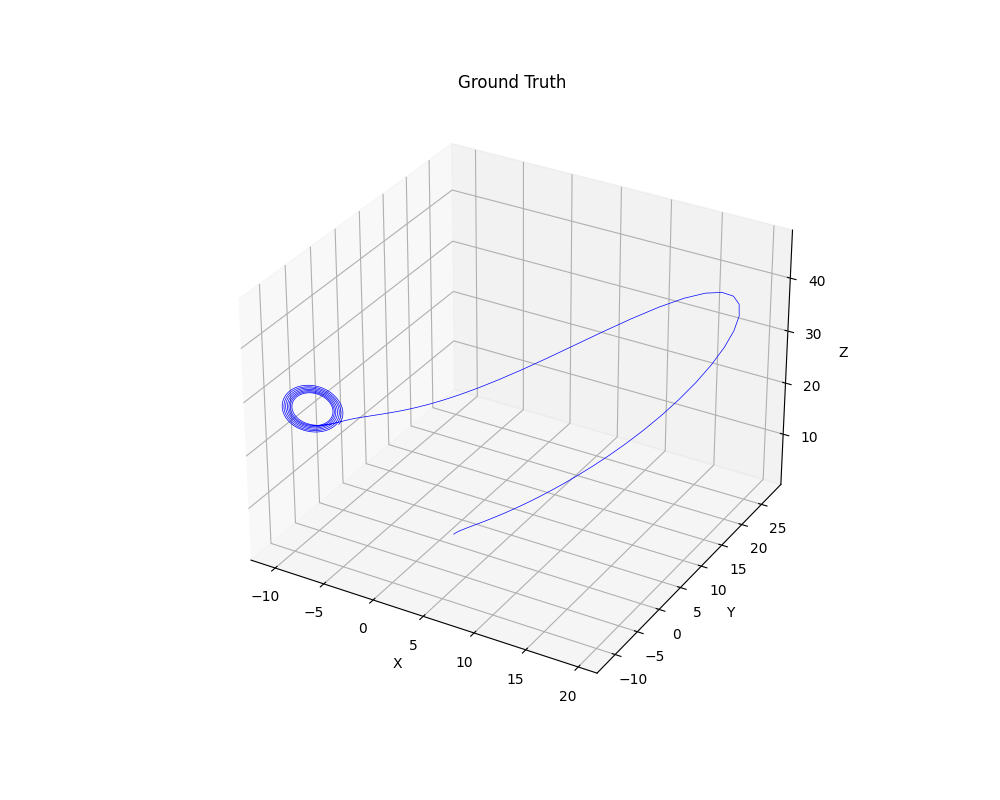

In [13]:
plot_trajectory_3d(original_data[:prediction_step], title="Ground Truth", figsize=(10, 8), linewidth=0.5, color='blue', show=True, save_path=None)

In [14]:
averge_loss = np.mean(original_data[:prediction_step] - pred.cpu().detach().numpy())
print(averge_loss)

-1.3715627405629143


### Latent Space 可视化

In [15]:
latent_pred = torch.zeros(x0.shape[0], 32)

temp_t, temp_tp1 = x0[0], x0[1]

for i in range(prediction_step):
    pred_out = koopman_ae_model(temp_t, temp_tp1)
    temp_t, temp_tp1 = temp_tp1, pred_out["x_tp1_pred"]
    latent_pred[i] = pred_out["z_t"]

# for i in range(prediction_step):
#     pred_out = koopman_ae_model(x0[i], x0[i+1])
#     latent_pred[i] = pred_out["z_t"]

latent_pred = latent_pred[:prediction_step]

print(latent_pred.shape)

torch.Size([501, 32])


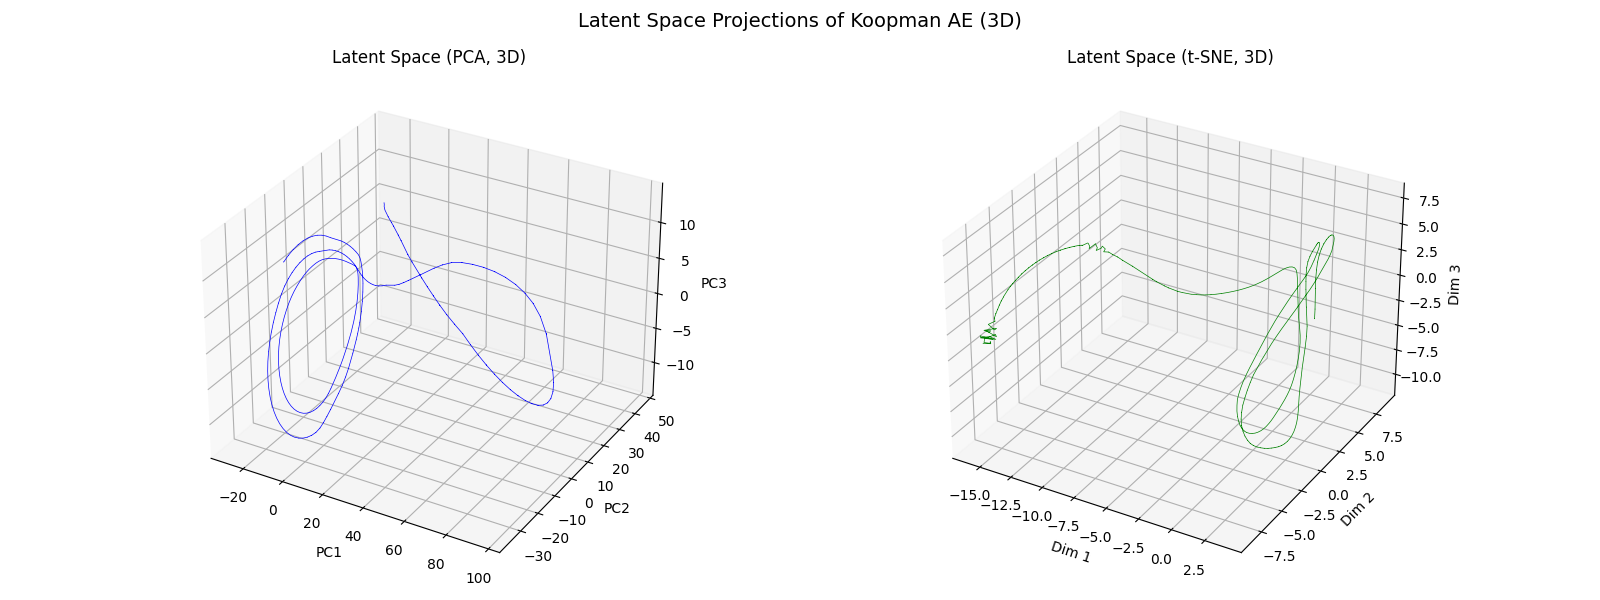

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# 确保 latent 是 numpy array
latent_np = latent_pred.cpu().detach().numpy() if isinstance(latent_pred, torch.Tensor) else latent_pred

# ========== 1. PCA 降维到 3D ==========
pca = PCA(n_components=3)
z_pca_3d = pca.fit_transform(latent_np)

# ========== 2. t-SNE 降维到 3D ==========
tsne = TSNE(n_components=3, perplexity=30, init='random', random_state=42)
z_tsne_3d = tsne.fit_transform(latent_np)

# ========== 3. 可视化 ==========
fig = plt.figure(figsize=(16, 6))

# --- PCA 3D ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(z_pca_3d[:, 0], z_pca_3d[:, 1], z_pca_3d[:, 2], color='blue', linewidth=0.5)
ax1.set_title("Latent Space (PCA, 3D)")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")

# --- t-SNE 3D ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(z_tsne_3d[:, 0], z_tsne_3d[:, 1], z_tsne_3d[:, 2], color='green', linewidth=0.5)
ax2.set_title("Latent Space (t-SNE, 3D)")
ax2.set_xlabel("Dim 1")
ax2.set_ylabel("Dim 2")
ax2.set_zlabel("Dim 3")

plt.suptitle("Latent Space Projections of Koopman AE (3D)", fontsize=14)
plt.tight_layout()
plt.show()
